In [2]:
from sklearn.model_selection import train_test_split
import os
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import sys
import math
from nltk.stem import PorterStemmer
from sklearn.datasets import load_iris
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import lil_matrix
from sklearn.feature_extraction.text import TfidfTransformer
import nltk
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
ps = PorterStemmer()
import pandas as pd
import re
import numpy as np
import tensorflow as tf
import sys

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Data Preprocessing

In [3]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

In [4]:
def preprocess_tweets(tweet):
    processed_tweet = []
    tweet = tweet.lower()
    regExp4 = re.compile(r'[.,;_()"/\']',re.DOTALL)
    tweet = regExp4.sub("",tweet)
    tweet = re.sub(r'[^\x00-\x7F]+','', tweet)
    words = tweet.split()
    for word in words:
        word = preprocess_word(word)
        if word not in stop_words:
            word = str(ps.stem(word))
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [5]:
def prepare_data(data):
    data=data.strip(',\n');
    #print(data)
    words=data.split()
    #print(words[1])
    question=""
    for i in range(len(words)-1):
        if i==0:
            question+=words[i]
        else:
            question+=" "+words[i]
    #print(question)
    label=words[-1];
    return question,label

In [28]:
data=pd.DataFrame(dict)
data.to_csv("process_questions.csv",index=False,header=True)   
stop_words = set(stopwords.words('english'))
df=pd.read_csv("process_questions.csv", encoding='utf-8')

## Train-Test split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentence'],df['Validity'], test_size=0.2,random_state=33)

In [16]:
corpus=df['Sentence']
uni_grams=[]
for sentence in corpus:
    words=sentence.split()
    for word in words:
        if word not in stop_words:
            uni_grams.append(ps.stem(word))
vocabsize=len(uni_grams)

vocab={}
for word in uni_grams:
    if word not in vocab:
        vocab[word]=0;
    vocab[word]+=1
vocab_size=len(vocab)
dim=200

In [19]:
def get_feature_vector(sentence):
    words = sentence.split()
    feature_vector = []
    for i in range(len(words) - 1):
        word = words[i]
        if vocab.get(word) is not None:
            feature_vector.append(vocab.get(word))
    if len(words) >= 1:
        if vocab.get(words[-1]) is not None:
            feature_vector.append(vocab.get(words[-1]))
    return feature_vector

In [20]:
def get_features(data):
    global uni_grams,vocabsize
    new_data=[]
    for sentence in data:
        words=sentence.split()
        features=[]
        for word in words:
            if word not in stop_words:
                features.append(ps.stem(word))
        new_data.append(features)
    trainsize=len(data)
    features = lil_matrix((trainsize, vocabsize))
    for i in range(len(new_data)):
        for j in range(len(new_data[i])):
            features[i,j]+=1;
    return features

In [21]:
def get_glove_vectors(vocab):
    print('Looking for GLOVE vectors')
    glove_vectors = {}
    found = 0
    with open('glove.twitter.27B.200d.txt', 'r') as glove_file:
        for i, line in enumerate(glove_file):
            #utils.write_status(i + 1, 0)
            tokens = line.split()
            word = tokens[0]
            if vocab.get(word):
                vector = [float(e) for e in tokens[1:]]
                glove_vectors[word] = np.array(vector)
                found += 1
    print('\n')
    print('Found %d words in GLOVE',found)
    return glove_vectors

## Embedding based Data representation

In [ ]:
glove_vectors = get_glove_vectors(vocab)
embedding_matrix = np.random.randn(vocab_size + 1, dim) * 0.01

for word, i in vocab.items():
        glove_vector = glove_vectors.get(word)
        if glove_vector is not None:
            embedding_matrix[i] = glove_vector

## Training and Testing Data

In [20]:
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

sentences=[]
for sentence in X_train:
    sentences.append(get_feature_vector(sentence))

labels=[]
for label in y_train:
    labels.append(label)
labels=np.array(labels)

sentences = pad_sequences(sentences, maxlen=40,padding='post')
shuffled_indices = np.random.permutation(sentences.shape[0])
sentences = sentences[shuffled_indices]
labels = labels[shuffled_indices]

# LSTM Classification Model

In [25]:
def Classication_Model():
    model = Sequential()
    model.add(Embedding(vocab_size + 1, dim, weights=[embedding_matrix], input_length=40))
    model.add(Dropout(0.25))
    model.add(LSTM(128))
    model.add(Dense(64))
    model.add(Dropout(0.25))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    return model

In [40]:
model = Classication_Model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Training 

In [41]:
history = model.fit(sentences, labels,validation_split = 0.1, epochs=50, batch_size=4)

Train on 382 samples, validate on 43 samples
Epoch 1/50
382/382 [==============================] - 4s 12ms/step - loss: 0.6123 - accuracy: 0.7330 - val_loss: 0.5790 - val_accuracy: 0.6977
Epoch 2/50
382/382 [==============================] - 4s 9ms/step - loss: 0.5901 - accuracy: 0.7304 - val_loss: 0.5675 - val_accuracy: 0.6977
Epoch 3/50
382/382 [==============================] - 4s 9ms/step - loss: 0.5848 - accuracy: 0.7304 - val_loss: 0.5748 - val_accuracy: 0.6977
Epoch 4/50
382/382 [==============================] - 4s 9ms/step - loss: 0.5735 - accuracy: 0.7304 - val_loss: 0.5670 - val_accuracy: 0.6977
Epoch 5/50
382/382 [==============================] - 4s 9ms/step - loss: 0.5544 - accuracy: 0.7330 - val_loss: 0.6918 - val_accuracy: 0.6744
Epoch 6/50
382/382 [==============================] - 4s 9ms/step - loss: 0.5562 - accuracy: 0.7304 - val_loss: 0.6017 - val_accuracy: 0.6977
Epoch 7/50
382/382 [==============================] - 4s 10ms/step - loss: 0.5507 - accuracy: 0.7304 -

## Plots

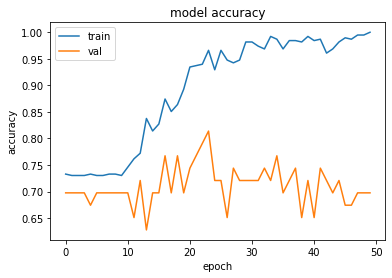

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

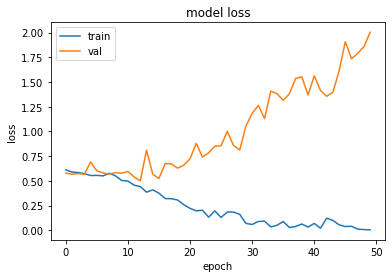

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Testing the Model 

In [50]:
test_sentences=[]
for sentence in X_test:
    test_sentences.append(get_feature_vector(sentence))

ground_truth=[]
for label in y_test:
    ground_truth.append(label)
ground_truth=np.array(ground_truth)

test_sentences = pad_sequences(test_sentences, maxlen=40,padding='post')

In [54]:
prediction = model.predict(test_sentences, batch_size=128, verbose=1)

107/107 [==============================] - 0s 2ms/step


In [58]:
results = zip(map(str, range(len(test_sentences))), np.round(prediction[:, 0]).astype(int))
output_labels=np.round(prediction[:, 0]).astype(int)

In [78]:
correct = 0
correct += np.sum(output_labels == ground_truth)
correct/len(prediction)

0.6355140186915887

### Accuracy is 63.55 %

# Naive Bayes Model

## Data Representation Using TF-IDF 

In [97]:
X_train=get_features(X_train)
transformer = TfidfTransformer(smooth_idf=True, sublinear_tf=True, use_idf=True)
transformer.fit(X_train)

TfidfTransformer(sublinear_tf=True)

In [26]:
X_train.todense()
X_train = transformer.transform(X_train)
X_test=get_features(X_test)
transformer.fit(X_test)
X_test = transformer.transform(X_test)
y=np.array(y_train)

## Training and Prediction

In [103]:
# train data
clf = MultinomialNB()
clf.fit(X_train,y)
y_test=np.array(y_test)

# test data
correct = 0
prediction = clf.predict(X_test)
correct += np.sum(prediction == y_test)
correct/len(prediction)

0.7511520737327189

### Accuracy is 75.11%